## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('train.csv', delimiter=',')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [3]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
87097,87097,146737,146738,Why China is threat to India?,Is China a threat to India?,1
174969,174969,81647,269518,"Why does 60 degrees outside feel comfortable, ...",What does -60 C/-76 F feels like?,0
84502,84502,31138,142863,How will demonetization affect India?,How demonetization and GST will affect Indian ...,0
227794,227794,336714,336715,What is a role of systems engineer in TCS?,What is the role of a systems reliabilty engin...,0
26664,26664,49596,49597,Who attends the MS double degree program in NI...,Is a Degree Certificate mandatory to apply for...,0


### Exploration

In [4]:
df.shape


(404290, 6)

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


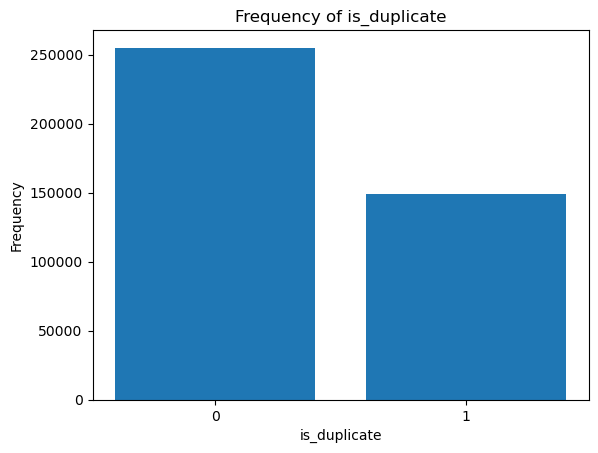

In [8]:
value_counts_labels= df['is_duplicate'].value_counts()

# Plot the frequency
plt.bar(value_counts_labels.index, value_counts_labels.values)
plt.xlabel('is_duplicate')
plt.ylabel('Frequency')
plt.title('Frequency of is_duplicate')
# Set the x-axis tick labels as integers
plt.xticks(value_counts_labels.index.astype(int))

plt.show()

The data is imbalanced

In [9]:
df['qid1'].nunique()

290654

We have 290654 unique questions out of 404290 in q1

In [10]:
df['qid2'].nunique()

299364

We have 299364 unique questions out of 404290 in q2

In [11]:
# looking for total unique questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

qid.nunique()


537933

In [12]:
# Drop rows with missing values in-place
df.dropna(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [14]:
# Removing punctuation
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# Define a function to remove punctuation in our messages
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [16]:
df['q1_clean'] = df['question1'].apply(lambda x: remove_punct(x))
df['q2_clean'] = df['question2'].apply(lambda x: remove_punct(x))

In [17]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean
76641,76641,130988,130989,How many atheists has William Lane Craig debat...,Who will win a debate between Dawkins and Will...,0,How many atheists has William Lane Craig debat...,Who will win a debate between Dawkins and Will...
79149,79149,134822,134823,What are the top hedge funds in Hong Kong?,What are the top quant hedge funds in Hong Kon...,0,What are the top hedge funds in Hong Kong,What are the top quant hedge funds in Hong Kon...
220304,220304,124646,65205,How can I hack other's Whatsapp account remotely?,How do I hack WhatsApp account of someone else...,1,How can I hack others Whatsapp account remotely,How do I hack WhatsApp account of someone else...
325622,325622,52329,451882,How much time does it take for activation of J...,How much time my Reliance Jio 4G SIM card will...,1,How much time does it take for activation of J...,How much time my Reliance Jio 4G SIM card will...
213076,213076,318311,318312,Does extra terrestrial inteligent life visit e...,When did extra terrestrial life discover life ...,1,Does extra terrestrial inteligent life visit e...,When did extra terrestrial life discover life ...
371373,371373,155008,28098,What hotel in Pune would be safe for unmarried...,What hotel in Barabanki would be safe for unma...,0,What hotel in Pune would be safe for unmarried...,What hotel in Barabanki would be safe for unma...
261517,261517,377682,43324,How one should get prepared for campus placement?,How should one prepare for campus placements?,1,How one should get prepared for campus placement,How should one prepare for campus placements
193580,193580,293527,293528,What is a steering system?,Do trains have a steering system?,0,What is a steering system,Do trains have a steering system
284861,284861,405195,405196,What would the U.S. be like today if the Frenc...,How did the French and Indian War start?,0,What would the US be like today if the French ...,How did the French and Indian War start
376530,376530,3540,227924,What can I do right now to help the people of ...,What can we do for the people of Aleppo?,1,What can I do right now to help the people of ...,What can we do for the people of Aleppo


In [18]:
import re

def tokenize(text):
    tokens = text.split()
    return tokens

In [19]:
df['q1_tokenized'] = df['q1_clean'].apply(lambda x: tokenize(x.lower()))
df['q2_tokenized'] = df['q2_clean'].apply(lambda x: tokenize(x.lower()))


In [20]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized
358085,358085,487519,487520,What is the proper length for men's pants?,What is the proper length for men's suit pants?,0,What is the proper length for mens pants,What is the proper length for mens suit pants,"[what, is, the, proper, length, for, mens, pants]","[what, is, the, proper, length, for, mens, sui..."
384324,384324,516348,516349,Website traffic analytics will show statistics...,Website traffic analytics will show statistics...,1,Website traffic analytics will show statistics...,Website traffic analytics will show statistics...,"[website, traffic, analytics, will, show, stat...","[website, traffic, analytics, will, show, stat..."
308641,308641,432503,432504,Does everything depend upon luck?,Why my luck is not favoring me despite a lot o...,0,Does everything depend upon luck,Why my luck is not favoring me despite a lot o...,"[does, everything, depend, upon, luck]","[why, my, luck, is, not, favoring, me, despite..."
253640,253640,368216,368217,How do volcanic ash clouds happen?,When and how did the volcanic ash cloud happen?,1,How do volcanic ash clouds happen,When and how did the volcanic ash cloud happen,"[how, do, volcanic, ash, clouds, happen]","[when, and, how, did, the, volcanic, ash, clou..."
337325,337325,464790,234237,Could I be experiencing nerve pain? In my uppe...,How can I relief pain from my cervical herniat...,0,Could I be experiencing nerve pain In my upper...,How can I relief pain from my cervical herniat...,"[could, i, be, experiencing, nerve, pain, in, ...","[how, can, i, relief, pain, from, my, cervical..."
130554,130554,209496,209497,Did Tony Stark make every one of his suits out...,Iron Man movie: How do they shoot the scenes w...,0,Did Tony Stark make every one of his suits out...,Iron Man movie How do they shoot the scenes wh...,"[did, tony, stark, make, every, one, of, his, ...","[iron, man, movie, how, do, they, shoot, the, ..."
71225,71225,122612,122613,What is the best team for Pokemon Heart Gold?,How do you find Rock Climb Pokemon in Heart Gold?,0,What is the best team for Pokemon Heart Gold,How do you find Rock Climb Pokemon in Heart Gold,"[what, is, the, best, team, for, pokemon, hear...","[how, do, you, find, rock, climb, pokemon, in,..."
18588,18588,35207,35208,Why did MS Dhoni retire from test cricket?,Why MS Dhoni retire from test?,1,Why did MS Dhoni retire from test cricket,Why MS Dhoni retire from test,"[why, did, ms, dhoni, retire, from, test, cric...","[why, ms, dhoni, retire, from, test]"
77587,77587,132438,132439,I have to write Article about art gallery how ...,Is writing about art easy?,0,I have to write Article about art gallery how ...,Is writing about art easy,"[i, have, to, write, article, about, art, gall...","[is, writing, about, art, easy]"
271320,271320,389379,389380,Why did Hamari Adhuri Kahani didn't deserve an...,What was the inspiration for Hamari Adhuri Kah...,0,Why did Hamari Adhuri Kahani didnt deserve any...,What was the inspiration for Hamari Adhuri Kahani,"[why, did, hamari, adhuri, kahani, didnt, dese...","[what, was, the, inspiration, for, hamari, adh..."


In [21]:
!pip install -U nltk

In [22]:
# Import the NLTK package and download the necessary data
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Define a function to remove all stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in stopwords.words('english')]
    return text

In [24]:
df['q1_nostop'] = df['q1_tokenized'].apply(lambda x: remove_stopwords(x))
df['q2_nostop'] = df['q2_tokenized'].apply(lambda x: remove_stopwords(x))

In [25]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop
135526,135526,74163,216399,How is india unique from other countries?,Why do we say India is a unique country?,1,How is india unique from other countries,Why do we say India is a unique country,"[how, is, india, unique, from, other, countries]","[why, do, we, say, india, is, a, unique, country]","[india, unique, countries]","[say, india, unique, country]"
55657,55657,98098,98099,How is natural selection related to evolution?,How does natural selection affect skin color?,0,How is natural selection related to evolution,How does natural selection affect skin color,"[how, is, natural, selection, related, to, evo...","[how, does, natural, selection, affect, skin, ...","[natural, selection, related, evolution]","[natural, selection, affect, skin, color]"
196411,196411,24297,34942,What is the easy way to make money online?,How can I earn money easily online?,1,What is the easy way to make money online,How can I earn money easily online,"[what, is, the, easy, way, to, make, money, on...","[how, can, i, earn, money, easily, online]","[easy, way, make, money, online]","[earn, money, easily, online]"
58180,58180,102115,102116,What are some show and tell ideas that begin w...,What are some show and tell ideas that begin w...,0,What are some show and tell ideas that begin w...,What are some show and tell ideas that begin w...,"[what, are, some, show, and, tell, ideas, that...","[what, are, some, show, and, tell, ideas, that...","[show, tell, ideas, begin, letter, j]","[show, tell, ideas, begin, letter, x]"
114886,114886,33031,185591,What are some successful ways to quit smoking?,How do I quit smoking? How?,1,What are some successful ways to quit smoking,How do I quit smoking How,"[what, are, some, successful, ways, to, quit, ...","[how, do, i, quit, smoking, how]","[successful, ways, quit, smoking]","[quit, smoking]"


In [26]:
# importing modules 
nltk.download('punkt')
from nltk.stem import PorterStemmer



[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# # Stem the tokens
stemmer = PorterStemmer()
df['q1_stemmed'] = df['q1_nostop'].apply(lambda x: [stemmer.stem(word) for word in x])
df['q2_stemmed'] = df['q2_nostop'].apply(lambda x: [stemmer.stem(word) for word in x])

In [28]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed
31763,31763,58543,58544,Can an illegal immigrant in the US sue a US ci...,Can a non-US citizen join the US army?,0,Can an illegal immigrant in the US sue a US ci...,Can a nonUS citizen join the US army,"[can, an, illegal, immigrant, in, the, us, sue...","[can, a, nonus, citizen, join, the, us, army]","[illegal, immigrant, us, sue, us, citizen]","[nonus, citizen, join, us, army]","[illeg, immigr, us, sue, us, citizen]","[nonu, citizen, join, us, armi]"
88985,88985,149576,149577,What is American paradox?,What is the purpose of biological and psycholo...,0,What is American paradox,What is the purpose of biological and psycholo...,"[what, is, american, paradox]","[what, is, the, purpose, of, biological, and, ...","[american, paradox]","[purpose, biological, psychological, theories]","[american, paradox]","[purpos, biolog, psycholog, theori]"
20590,20590,38834,38835,How do you know if you are in an emotionally a...,How do I know if I was in a mutually abusive r...,1,How do you know if you are in an emotionally a...,How do I know if I was in a mutually abusive r...,"[how, do, you, know, if, you, are, in, an, emo...","[how, do, i, know, if, i, was, in, a, mutually...","[know, emotionally, abusive, relationship]","[know, mutually, abusive, relationship]","[know, emot, abus, relationship]","[know, mutual, abus, relationship]"
139355,139355,221692,221693,How much would replacing a cracked Micromax Ca...,How can I set the 3G settings in the Micromax ...,0,How much would replacing a cracked Micromax Ca...,How can I set the 3G settings in the Micromax ...,"[how, much, would, replacing, a, cracked, micr...","[how, can, i, set, the, 3g, settings, in, the,...","[much, would, replacing, cracked, micromax, ca...","[set, 3g, settings, micromax, bolt, a065]","[much, would, replac, crack, micromax, canva, ...","[set, 3g, set, micromax, bolt, a065]"
134149,134149,214467,214468,How do the railway networks work?,How railway network works?,1,How do the railway networks work,How railway network works,"[how, do, the, railway, networks, work]","[how, railway, network, works]","[railway, networks, work]","[railway, network, works]","[railway, network, work]","[railway, network, work]"


In [29]:
# Define a function to calculate the count of a tokenized list
def count_tokens(tokenized_list):
    return len(tokenized_list)

# Apply the function to the 'text' column
df['q1_count'] = df['q1_tokenized'].apply(count_tokens)
df['q2_count'] = df['q2_tokenized'].apply(count_tokens)

In [30]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count
39409,39409,8660,53534,Why can you not accelerate to faster than light?,Why can't anything go faster than light?,1,Why can you not accelerate to faster than light,Why cant anything go faster than light,"[why, can, you, not, accelerate, to, faster, t...","[why, cant, anything, go, faster, than, light]","[accelerate, faster, light]","[cant, anything, go, faster, light]","[acceler, faster, light]","[cant, anyth, go, faster, light]",9,7
374335,374335,242795,505232,Is impact factor of 3.6 can be considered good...,How do you interpret impact factor of journals?,0,Is impact factor of 36 can be considered good ...,How do you interpret impact factor of journals,"[is, impact, factor, of, 36, can, be, consider...","[how, do, you, interpret, impact, factor, of, ...","[impact, factor, 36, considered, good, indian,...","[interpret, impact, factor, journals]","[impact, factor, 36, consid, good, indian, jou...","[interpret, impact, factor, journal]",13,8
215163,215163,1893,24233,Why is Saltwater taffy candy imported in Austr...,Why is Saltwater taffy candy imported in South...,1,Why is Saltwater taffy candy imported in Austr...,Why is Saltwater taffy candy imported in South...,"[why, is, saltwater, taffy, candy, imported, i...","[why, is, saltwater, taffy, candy, imported, i...","[saltwater, taffy, candy, imported, australia]","[saltwater, taffy, candy, imported, south, korea]","[saltwat, taffi, candi, import, australia]","[saltwat, taffi, candi, import, south, korea]",8,9
249954,249954,363703,363704,What are the advantages and disadvantages of t...,How do I use the pad in MMA?,0,What are the advantages and disadvantages of t...,How do I use the pad in MMA,"[what, are, the, advantages, and, disadvantage...","[how, do, i, use, the, pad, in, mma]","[advantages, disadvantages, tampons, sanitary,...","[use, pad, mma]","[advantag, disadvantag, tampon, sanitari, napkin]","[use, pad, mma]",11,8
368798,368798,105419,56578,How do you make money with Quora?,How can we earn from Quora?,1,How do you make money with Quora,How can we earn from Quora,"[how, do, you, make, money, with, quora]","[how, can, we, earn, from, quora]","[make, money, quora]","[earn, quora]","[make, money, quora]","[earn, quora]",7,6
93061,93061,28602,33981,What was the most embarrassing moment of yours?,What is most embarrassing moment of your life?,1,What was the most embarrassing moment of yours,What is most embarrassing moment of your life,"[what, was, the, most, embarrassing, moment, o...","[what, is, most, embarrassing, moment, of, you...","[embarrassing, moment]","[embarrassing, moment, life]","[embarrass, moment]","[embarrass, moment, life]",8,8
216931,216931,323181,323182,Will I face any legal problems if I do binary ...,"Is binary trading legal in India? If not, then...",0,Will I face any legal problems if I do binary ...,Is binary trading legal in India If not then w...,"[will, i, face, any, legal, problems, if, i, d...","[is, binary, trading, legal, in, india, if, no...","[face, legal, problems, binary, options, tradi...","[binary, trading, legal, india, yes, legal, si...","[face, legal, problem, binari, option, trade, ...","[binari, trade, legal, india, ye, legal, sinc,...",14,27
43052,43052,77496,77497,Is anyone here who have done msc from UK?,How do I fix my story writing?,0,Is anyone here who have done msc from UK,How do I fix my story writing,"[is, anyone, here, who, have, done, msc, from,...","[how, do, i, fix, my, story, writing]","[anyone, done, msc, uk]","[fix, story, writing]","[anyon, done, msc, uk]","[fix, stori, write]",9,7
207158,207158,64045,310780,What will happen to the Sun when it dies?,What happens to a planetary system when its su...,1,What will happen to the Sun when it dies,What happens to a planetary system when its su...,"[what, will, happen, to, the, sun, when, it, d...","[what, happens, to, a, pl

In [31]:
# Define a function to calculate the intersection of words
def calculate_intersection(row):
    set1 = set(row['q1_tokenized'])
    set2 = set(row['q2_tokenized'])
    intersection = set1.intersection(set2)
    return intersection

# Apply the function to each row
df['intersection_q1_q2_token'] = df.apply(calculate_intersection, axis=1)

In [32]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token
395299,395299,190515,400976,Which is the most popular hybrid mobile app fr...,What is the Best framework for hybrid mobile app?,0,Which is the most popular hybrid mobile app fr...,What is the Best framework for hybrid mobile app,"[which, is, the, most, popular, hybrid, mobile...","[what, is, the, best, framework, for, hybrid, ...","[popular, hybrid, mobile, app, framework]","[best, framework, hybrid, mobile, app]","[popular, hybrid, mobil, app, framework]","[best, framework, hybrid, mobil, app]",9,9,"{is, the, app, mobile, framework, hybrid}"
368882,368882,193793,499295,What calms mind?,What are good ways to relax and calm the mind?,0,What calms mind,What are good ways to relax and calm the mind,"[what, calms, mind]","[what, are, good, ways, to, relax, and, calm, ...","[calms, mind]","[good, ways, relax, calm, mind]","[calm, mind]","[good, way, relax, calm, mind]",3,10,"{what, mind}"
247312,247312,165050,360518,Is it possible to have an out-of-body experience?,How does an out of body experience happen?,0,Is it possible to have an outofbody experience,How does an out of body experience happen,"[is, it, possible, to, have, an, outofbody, ex...","[how, does, an, out, of, body, experience, hap...","[possible, outofbody, experience]","[body, experience, happen]","[possibl, outofbodi, experi]","[bodi, experi, happen]",8,8,"{experience, an}"
121642,121642,138157,166633,What are your top 5 movies for 2016?,What are your top 10 favourite movies of 2016?,1,What are your top 5 movies for 2016,What are your top 10 favourite movies of 2016,"[what, are, your, top, 5, movies, for, 2016]","[what, are, your, top, 10, favourite, movies, ...","[top, 5, movies, 2016]","[top, 10, favourite, movies, 2016]","[top, 5, movi, 2016]","[top, 10, favourit, movi, 2016]",8,9,"{your, movies, top, are, 2016, what}"
301832,301832,27636,138229,How do I get to speak fluently English?,How can I learn & speak & write English?,1,How do I get to speak fluently English,How can I learn speak write English,"[how, do, i, get, to, speak, fluently, english]","[how, can, i, learn, speak, write, english]","[get, speak, fluently, english]","[learn, speak, write, english]","[get, speak, fluentli, english]","[learn, speak, write, english]",8,7,"{english, i, speak, how}"
132007,132007,211493,211494,Should I drop AP Physics 1? Its really hard at...,AP Physics was removed from our school because...,0,Should I drop AP Physics 1 Its really hard at ...,AP Physics was removed from our school because...,"[should, i, drop, ap, physics, 1, its, really,...","[ap, physics, was, removed, from, our, school,...","[drop, ap, physics, 1, really, hard, school, t...","[ap, physics, removed, school, half, class, fo...","[drop, ap, physic, 1, realli, hard, school, te...","[ap, physic, remov, school, half, class, found...",29,27,"{because, ap, physics, hard, school, i, it}"
154382,154382,242124,101152,Which is the best way to invest in stock market?,Finance: Which is the best way to learn about ...,0,Which is the best way to invest in stock market,Finance Which is the best way to learn about s...,"[which, is, the, best, way, to, invest, in, st...","[finance, which, is, the, best, way, to, learn...","[best, way, invest, stock, market]","[finance, best, way, learn, stocks]","[best, way, invest, stock, market]","[financ, best, way, learn, stock]",10,10,"{to, which, is, the, best, way}"
114695,114695,187178,187179,Why is theOddOne so good at League of Legends?,Is League of Legends a good game? Why or why not?,0,Why is theOddOne so good at League of Legends,Is League of Legends a good game Why or why not,"[why, is, theoddone, so, good, at, league, of,...","[is, league, of, legends, a, good, game, why, ...","[theoddone, good, league, legends]","[league, legends, good, game]","[theoddon, good, leagu, legend]","[leagu, legend, good, 

In [33]:
df['intersection_q1_q2_token_count'] = df['intersection_q1_q2_token'].apply(count_tokens)

In [34]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token,intersection_q1_q2_token_count
34013,34013,62389,62390,What anime character is this?,What is it like to be an anime character?,0,What anime character is this,What is it like to be an anime character,"[what, anime, character, is, this]","[what, is, it, like, to, be, an, anime, charac...","[anime, character]","[like, anime, character]","[anim, charact]","[like, anim, charact]",5,9,"{anime, what, is, character}",4
71606,71606,123189,123190,Why is kinetic energy important?,How is kinetic energy measured?,0,Why is kinetic energy important,How is kinetic energy measured,"[why, is, kinetic, energy, important]","[how, is, kinetic, energy, measured]","[kinetic, energy, important]","[kinetic, energy, measured]","[kinet, energi, import]","[kinet, energi, measur]",5,5,"{kinetic, is, energy}",3
57330,57330,100755,100756,What are some of the best websites to make a f...,What is the best free YouTube website to prepa...,0,What are some of the best websites to make a f...,What is the best free YouTube website to prepa...,"[what, are, some, of, the, best, websites, to,...","[what, is, the, best, free, youtube, website, ...","[best, websites, make, free, youtube, intro]","[best, free, youtube, website, prepare, jam, e...","[best, websit, make, free, youtub, intro]","[best, free, youtub, websit, prepar, jam, exam]",13,12,"{to, free, youtube, the, best, what}",6
376728,376728,507927,507928,How many students enroll for studying in Reson...,How many students on average enroll every year...,1,How many students enroll for studying in Reson...,How many students on average enroll every year...,"[how, many, students, enroll, for, studying, i...","[how, many, students, on, average, enroll, eve...","[many, students, enroll, studying, resonance, ...","[many, students, average, enroll, every, year,...","[mani, student, enrol, studi, reson, kota, eng...","[mani, student, averag, enrol, everi, year, re...",19,17,"{enroll, average, many, engineering, resonance...",15
101190,101190,167688,167689,What are the advantages to having two wheels a...,Why do heavy vehicles have four wheels at rear...,0,What are the advantages to having two wheels a...,Why do heavy vehicles have four wheels at rear...,"[what, are, the, advantages, to, having, two, ...","[why, do, heavy, vehicles, have, four, wheels,...","[advantages, two, wheels, front, instead, back...","[heavy, vehicles, four, wheels, rear, two, front]","[advantag, two, wheel, front, instead, back, t...","[heavi, vehicl, four, wheel, rear, two, front]",20,13,"{two, wheels, at, front}",4
81490,81490,138350,138351,What is Manila?,What should I do in Manila?,0,What is Manila,What should I do in Manila,"[what, is, manila]","[what, should, i, do, in, manila]",[manila],[manila],[manila],[manila],3,6,"{what, manila}",2
31108,31108,57379,57380,What is the best way to make bank account tran...,How can I make a bank account transfer?,1,What is the best way to make bank account tran...,How can I make a bank account transfer,"[what, is, the, best, way, to, make, bank, acc...","[how, can, i, make, a, bank, account, transfer]","[best, way, make, bank, account, transfer]","[make, bank, account, transfer]","[best, way, make, bank, account, transfer]","[make, bank, account, transfer]",10,8,"{bank, make, transfer, account}",4
100467,100467,166641,166642,Can you buy real Maiko's and Geisha's old things?,Man have 7 rebirths it is fact or a belief?,0,Can you buy real Maikos and Geishas old things,Man have 7 rebirths it is fact or a belief,"[can, you, buy, real, maikos, and, geishas, ol...","[man, have, 7, rebirths, it, is, fact, or, a, ...","[buy, real, maikos, geishas, old, things]","[man, 7, rebirths, fact, belief]","[buy, real, maiko, geisha, old, thing]","[man, 7, rebirth, fact, belief]",9,10,{},0
394779,394779,224753,82772,What are some cultural faux pas among

In [35]:
 # # Join the tokens back into a single string
df['q1_stemmed_j'] = df['q1_stemmed'].apply(lambda x: ' '.join(x))
df['q2_stemmed_j'] = df['q2_stemmed'].apply(lambda x: ' '.join(x))

In [36]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token,intersection_q1_q2_token_count,q1_stemmed_j,q2_stemmed_j
122592,122592,13772,198389,How do you find your health insurance policy n...,Is there any thing we can do to beat the healt...,0,How do you find your health insurance policy n...,Is there any thing we can do to beat the healt...,"[how, do, you, find, your, health, insurance, ...","[is, there, any, thing, we, can, do, to, beat,...","[find, health, insurance, policy, number]","[thing, beat, health, insurance, policy, us]","[find, health, insur, polici, number]","[thing, beat, health, insur, polici, us]",9,16,"{health, do, policy, insurance}",4,find health insur polici number,thing beat health insur polici us
178644,178644,274317,274318,Can I bypass Android lockscreen?,I am the only guy in my gymnastics class? Is t...,0,Can I bypass Android lockscreen,I am the only guy in my gymnastics class Is th...,"[can, i, bypass, android, lockscreen]","[i, am, the, only, guy, in, my, gymnastics, cl...","[bypass, android, lockscreen]","[guy, gymnastics, class, weird]","[bypass, android, lockscreen]","[guy, gymnast, class, weird]",5,12,{i},1,bypass android lockscreen,guy gymnast class weird
53647,53647,94811,94812,What are some independent films with CGI?,Why are films these days so full of CGI?,0,What are some independent films with CGI,Why are films these days so full of CGI,"[what, are, some, independent, films, with, cgi]","[why, are, films, these, days, so, full, of, cgi]","[independent, films, cgi]","[films, days, full, cgi]","[independ, film, cgi]","[film, day, full, cgi]",7,9,"{cgi, films, are}",3,independ film cgi,film day full cgi
84600,84600,143012,143013,Can you remove a turtle from its shell without...,Can turtles go inside their shells when they a...,0,Can you remove a turtle from its shell without...,Can turtles go inside their shells when they a...,"[can, you, remove, a, turtle, from, its, shell...","[can, turtles, go, inside, their, shells, when...","[remove, turtle, shell, without, killing]","[turtles, go, inside, shells, underwater]","[remov, turtl, shell, without, kill]","[turtl, go, insid, shell, underwat]",11,10,{can},1,remov turtl shell without kill,turtl go insid shell underwat
139858,139858,21376,222366,Is Donald Trump gonna end in a conflicts but n...,Is Donald Trump gonna end in conflicts but not...,1,Is Donald Trump gonna end in a conflicts but n...,Is Donald Trump gonna end in conflicts but not...,"[is, donald, trump, gonna, end, in, a, conflic...","[is, donald, trump, gonna, end, in, conflicts,...","[donald, trump, gonna, end, conflicts, quit, e...","[donald, trump, gonna, end, conflicts, quit, e...","[donald, trump, gonna, end, conflict, quit, el...","[donald, trump, gonna, end, conflict, quit, el...",14,13,"{elected, quit, gonna, trump, is, conflicts, a...",13,donald trump gonna end conflict quit elect presid,donald trump gonna end conflict quit elect presid


In [37]:
df['min_value'] = df[['q1_count', 'q2_count']].min(axis=1)
df['max_value'] = df[['q1_count', 'q2_count']].max(axis=1)

df['perc_count_min'] = df['intersection_q1_q2_token_count'] / df['min_value']
df['perc_count_max'] = df['intersection_q1_q2_token_count'] / df['max_value']

In [38]:
df.isnull().sum()

id                                 0
qid1                               0
qid2                               0
question1                          0
question2                          0
is_duplicate                       0
q1_clean                           0
q2_clean                           0
q1_tokenized                       0
q2_tokenized                       0
q1_nostop                          0
q2_nostop                          0
q1_stemmed                         0
q2_stemmed                         0
q1_count                           0
q2_count                           0
intersection_q1_q2_token           0
intersection_q1_q2_token_count     0
q1_stemmed_j                       0
q2_stemmed_j                       0
min_value                          0
max_value                          0
perc_count_min                    14
perc_count_max                     0
dtype: int64

In [39]:
df_processed= df[['q1_stemmed_j','q2_stemmed_j','is_duplicate','intersection_q1_q2_token_count','perc_count_min','perc_count_max']]
df_processed.head()

,q1_stemmed_j,q2_stemmed_j,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
0,step step guid invest share market india,step step guid invest share market,0,11,0.916667,0.785714
1,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,4,0.500000,0.307692
2,increas speed internet connect use vpn,internet speed increas hack dn,0,4,0.400000,0.285714
3,mental lone solv,find remaind math2324math divid 2423,0,0,0.000000,0.000000
4,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,4,0.571429,0.307692


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [40]:
df_sample = df_processed.sample(30000, random_state=42)

In [41]:
#BOW

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import numpy as np

# Assuming df_processed is your DataFrame and 'q1_stemmed_j' and 'q2_stemmed_j' are the columns containing text

# Merge the texts
questions = list(df_sample['q1_stemmed_j']) + list(df_sample['q2_stemmed_j'])

# Create an instance of CountVectorizer
cv = CountVectorizer(min_df=2, max_features=3000)

# Transform the questions into a sparse matrix
matrix = cv.fit_transform(questions)

# Convert the sparse matrix to a dense array
matrix = matrix.toarray()

# Split the transformed arrays into q1_arr and q2_arr
q1_arr, q2_arr = np.vsplit(matrix, 2)


In [43]:
# from sklearn.metrics.pairwise import cosine_similarity
# # Calculate cosine similarity between q1_arr and q2_arr
# cos_sim = cosine_similarity(q1_arr, q2_arr)
# # Calculate similarity value for each row pair and add as a new column
# similarity_values = cos_sim.diagonal()

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
# Define batch size
batch_size = 1000

# Initialize similarity_values list with NaN
similarity_values = [np.nan] * len(df_sample)

# Calculate similarity value for each pair of q1 and q2 in smaller batches
num_rows = len(df_sample)
for start_idx in range(0, num_rows, batch_size):
    end_idx = min(start_idx + batch_size, num_rows)
    q1_batch = matrix[start_idx:end_idx]
    q2_batch = matrix[start_idx + num_rows:end_idx + num_rows]
    
    if q1_batch.shape[0] == 0 or q2_batch.shape[0] == 0:
        continue  # Skip empty batches
    
    batch_similarities = cosine_similarity(q1_batch, q2_batch).diagonal()
    similarity_values[start_idx:end_idx] = batch_similarities

# Add the similarity column to the DataFrame
df_sample['similarity'] = similarity_values

In [45]:
df1=pd.DataFrame(q1_arr, index=df_sample.index)
df2=pd.DataFrame(q2_arr, index=df_sample.index)
df_final=pd.concat([df1,df2],axis=1)
df_final['similarity'] = df_sample['similarity']

In [46]:
df_final.shape

(30000, 6001)

In [47]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,similarity
8067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.750000
224279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
252452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
174039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
384863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.516398


In [48]:
df_final['is_duplicate']=df_sample['is_duplicate']
df_final['intersection_q1_q2_token_count']=df_sample['intersection_q1_q2_token_count']
df_final['perc_count_min']=df_sample['perc_count_min']
df_final['perc_count_max']=df_sample['perc_count_max']

In [49]:
df_final.shape

(30000, 6005)

In [50]:
df_final.head()


,0,1,2,3,4,5,6,7,8,9,...,2995,2996,2997,2998,2999,similarity,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
8067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.750000,0,7,0.875000,0.875000
224279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.500000,0,2,0.285714,0.181818
252452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0,2,0.285714,0.095238
174039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0,0,0.000000,0.000000
384863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.516398,1,5,0.714286,0.454545


In [51]:
df_final['is_duplicate'].value_counts()


is_duplicate
0    18927
1    11073
Name: count, dtype: int64

In [52]:
#Tf-idf

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np

# Assuming df_processed is your DataFrame and 'q1_stemmed_j' and 'q2_stemmed_j' are the columns containing text

# Merge the texts
questions = list(df_sample['q1_stemmed_j']) + list(df_sample['q2_stemmed_j'])

# Create an instance of CountVectorizer
Td = TfidfVectorizer(min_df=2, max_features=3000)

# Transform the questions into a sparse matrix
matrix = Td.fit_transform(questions)

# Convert the sparse matrix to a dense array
matrix = matrix.toarray()

# Split the transformed arrays into q1_arr and q2_arr
q1_arr_tf, q2_arr_tf = np.vsplit(matrix, 2)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
# Define batch size
batch_size = 1000

# Initialize similarity_values list with NaN
similarity_values = [np.nan] * len(df_sample)

# Calculate similarity value for each pair of q1 and q2 in smaller batches
num_rows = len(df_sample)
for start_idx in range(0, num_rows, batch_size):
    end_idx = min(start_idx + batch_size, num_rows)
    q1_batch = matrix[start_idx:end_idx]
    q2_batch = matrix[start_idx + num_rows:end_idx + num_rows]
    
    if q1_batch.shape[0] == 0 or q2_batch.shape[0] == 0:
        continue  # Skip empty batches
    
    batch_similarities = cosine_similarity(q1_batch, q2_batch).diagonal()
    similarity_values[start_idx:end_idx] = batch_similarities

# Add the similarity column to the DataFrame
df_sample['similarity_tf'] = similarity_values

In [55]:
df1_tf=pd.DataFrame(q1_arr_tf, index=df_sample.index)
df2_tf=pd.DataFrame(q2_arr_tf, index=df_sample.index)
df_final_tf=pd.concat([df1,df2],axis=1)
df_final_tf['similarity'] = df_sample['similarity_tf']

In [56]:
df_final_tf.shape

(30000, 6001)

In [57]:
df_final_tf['is_duplicate']=df_sample['is_duplicate']
df_final_tf['intersection_q1_q2_token_count']=df_sample['intersection_q1_q2_token_count']
df_final_tf['perc_count_min']=df_sample['perc_count_min']
df_final_tf['perc_count_max']=df_sample['perc_count_max']

In [58]:
df_final_tf.shape

(30000, 6005)

In [59]:
df_final_tf.head()

,0,1,2,3,4,5,6,7,8,9,...,2995,2996,2997,2998,2999,similarity,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
8067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.709093,0,7,0.875000,0.875000
224279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.533659,0,2,0.285714,0.181818
252452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0,2,0.285714,0.095238
174039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0,0,0.000000,0.000000
384863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.541706,1,5,0.714286,0.454545


In [60]:
Word2Vec

In [61]:
# !pip install gensim

In [62]:
# import gensim
# from gensim.models import Word2Vec

In [63]:
# Concatenate the tokenized words from 'q1_tokenized' and 'q2_tokenized'
sentences = df['q1_tokenized'].tolist() + df['q2_tokenized'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model
model.save("word2vec.model")

In [64]:
# df_word2vec = df[['word2vec_q1','word2vec_q2']]

In [65]:
# df['word2vec_q1'] = df['q1_tokenized'].apply(lambda x: np.mean([model.wv[word] for word in x], axis=0))
# df['word2vec_q2'] = df['q2_tokenized'].apply(lambda x: np.mean([model.wv[word] for word in x], axis=0))


In [66]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Calculate the similarity values between 'word2vec_q2' and 'word2vec_q1'
# similarity_values = cosine_similarity(df_word2vec['word2vec_q2'].tolist(), df_word2vec['word2vec_q1'].tolist())

# # Add the similarity values as a new column in the DataFrame
# df_word2vec['similarity_values'] = similarity_values

In [ ]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Set the desired length for the word vectors
# vector_length = 100

# # Get the word vectors for each question in 'q1' and 'q2'
# df['word2vec_q1'] = df['q1_tokenized'].apply(lambda x: [model.wv[word] for word in x])
# df['word2vec_q2'] = df['q2_tokenized'].apply(lambda x: [model.wv[word] for word in x])

# # Pad or truncate the word vectors to the desired length
# df['word2vec_q1'] = df['word2vec_q1'].apply(lambda x: pad_sequences([x], maxlen=vector_length, dtype='float32', padding='post', truncating='post')[0])
# df['word2vec_q2'] = df['word2vec_q2'].apply(lambda x: pad_sequences([x], maxlen=vector_length, dtype='float32', padding='post', truncating='post')[0])

2023-06-05 23:30:07.673285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 23:30:08.055342: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Calculate the similarity values between 'word2vec_q2' and 'word2vec_q1'
# similarity_values = cosine_similarity(df_word2vec['word2vec_q2'].tolist(), df_word2vec['word2vec_q1'].tolist())

# # Add the similarity values as a new column in the DataFrame
# df_word2vec['similarity_values'] = similarity_values

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

NameError: name 'df_final' is not defined